# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Read-processed-dmstack-files" data-toc-modified-id="Read-processed-dmstack-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read processed dmstack files</a></div><div class="lev1 toc-item"><a href="#Look-at-first-lsst-file-(lsst_000)" data-toc-modified-id="Look-at-first-lsst-file-(lsst_000)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Look at first lsst file (lsst_000)</a></div><div class="lev1 toc-item"><a href="#Create-new-columns" data-toc-modified-id="Create-new-columns-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create new columns</a></div><div class="lev1 toc-item"><a href="#Distribution-of-e_sq" data-toc-modified-id="Distribution-of-e_sq-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Distribution of e_sq</a></div><div class="lev1 toc-item"><a href="#Distance-of-objects-in-a-file-from-cetroid-of-that-file" data-toc-modified-id="Distance-of-objects-in-a-file-from-cetroid-of-that-file-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Distance of objects in a file from cetroid of that file</a></div><div class="lev1 toc-item"><a href="#Bad-density-percentage-of-100-lsst-files" data-toc-modified-id="Bad-density-percentage-of-100-lsst-files-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Bad density percentage of 100 lsst files</a></div>

# Introduction

Date: Jul 17, 2019

1. In jedisim we used ngals = 10k, z = 1.5 and did 100 simulations. jedisim gives l,l9,m,m9 for each 100 simulations (total 100*4 = 400 fitsfiles).

2. Dmstack gives 400 csv files from 400 jedisim outputs.
   Each csv output has 90 flags and 76 parameters.

3. After dmstack we clean and filter csv fiels to get txt files with 
   few columns of    interest. 
   - no nans
   - e <= 1.5,
   - not psf candidate
   - have no child.

4. We use combine four txt files l.txt, l9.txt, m.txt, m9.txt in IMCAT
   and get final0.cat
   and combine 100 final.cat files to get final.cat and then final_text.txt file.

5. The output of imcat program final_text.txt has more columns than txt output of
   processed dmstack output.
   ```
   fN    00 10 20 30  # fN means file number
   id    00 10 20 30
   flux  00 10 20 30

   x  0 1
   gm 0 1
   gc 0 1
   
   errx 00 01 10 11 20 21 30 31
   g    00 01 10 11 20 21 30 31 # there is no erry here in imcat output
   
   So, in total there are
   3 * 4 + 3 * 2 + 2 * 8 = 8 + 6 + 16 = 34 columns in final.cat file.
   ```
   
**Previous Work**  
I found there are many objects which have 0.7 < gm_sq < 1.0. I need to find out
where are they in the original fitsfiles.

**Current Work**  
- The dmstack work on the jedisim_output + wcs + psf fitsfile.
- I calculated centroid (center of mass) of 400 fitsfiles
  using scipy ndimage center of mass.
- I looked at the each of 400 files and their portion of objects in the range
  0.7 < gm_sq < 1.0 and their distance from the centroid.

# Read processed dmstack files

In [1]:
!ls ../a08_july5_2019/*.txt | head # This gives lsst90 but I look at lsst

../a08_july5_2019/src_lsst90_z1.5_000.txt
../a08_july5_2019/src_lsst90_z1.5_001.txt
../a08_july5_2019/src_lsst90_z1.5_002.txt
../a08_july5_2019/src_lsst90_z1.5_003.txt
../a08_july5_2019/src_lsst90_z1.5_004.txt
../a08_july5_2019/src_lsst90_z1.5_005.txt
../a08_july5_2019/src_lsst90_z1.5_006.txt
../a08_july5_2019/src_lsst90_z1.5_007.txt
../a08_july5_2019/src_lsst90_z1.5_008.txt
../a08_july5_2019/src_lsst90_z1.5_009.txt


In [2]:
!head -2 ../a08_july5_2019/src_lsst_z1.5_000.txt

# file_number           id           base_SdssCentroid_x           base_SdssCentroid_y           base_SdssCentroid_xSigma           base_SdssCentroid_ySigma           ext_shapeHSM_HsmShapeRegauss_e1           ext_shapeHSM_HsmShapeRegauss_e2           base_SdssShape_flux
0.000000000000000000e+00	3.000000000000000000e+01	1.877364299999999957e+03	2.783330000000000126e+01	3.300000000000000155e-01	2.990999999999999770e-01	1.607999999999999985e-01	-2.922000000000000153e-01	3.044910100000000057e+03


In [3]:
# Now we will read file using pandas

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import scipy
import scipy.stats as stats

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 500)

%load_ext version_information
%version_information numpy,  scipy, pandas, sklearn, matplotlib, seaborn

Software versions
Python 3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 7.4.0
OS Darwin 14.5.0 x86_64 i386 64bit
numpy 1.11.0
scipy 0.19.0
pandas 0.20.0
sklearn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1
Fri Jul 19 11:03:41 2019 EDT

In [5]:
%%javascript

/* show long output*/
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Look at first lsst file (lsst_000)

In [6]:
# the column is commented in datafile, just read the header line
# read the  first row only and use separator whitspace.
infile = '../a08_july5_2019/src_lsst_z1.5_000.txt'
headers = pd.read_csv(infile,sep=r'\s+',nrows=1).columns

headers = headers[1:] # remove first # column
headers

Index(['file_number', 'id', 'base_SdssCentroid_x', 'base_SdssCentroid_y',
       'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma',
       'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2',
       'base_SdssShape_flux'],
      dtype='object')

In [7]:
df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None)
df.columns = headers
print(df.shape)
df.head(1).append(df.tail(1)).T

(2044, 9)


,0,2043
file_number,0.0000,0.0000
id,30.0000,7572.0000
base_SdssCentroid_x,1877.3643,30.9955
base_SdssCentroid_y,27.8333,3344.8463
base_SdssCentroid_xSigma,0.3300,0.0555
base_SdssCentroid_ySigma,0.2991,0.0575
ext_shapeHSM_HsmShapeRegauss_e1,0.1608,-0.1726
ext_shapeHSM_HsmShapeRegauss_e2,-0.2922,-0.0006
base_SdssShape_flux,3044.9101,7238.3610


In [8]:
!head -2 ../a08_july5_2019/src_lsst_z1.5_000.txt

# file_number           id           base_SdssCentroid_x           base_SdssCentroid_y           base_SdssCentroid_xSigma           base_SdssCentroid_ySigma           ext_shapeHSM_HsmShapeRegauss_e1           ext_shapeHSM_HsmShapeRegauss_e2           base_SdssShape_flux
0.000000000000000000e+00	3.000000000000000000e+01	1.877364299999999957e+03	2.783330000000000126e+01	3.300000000000000155e-01	2.990999999999999770e-01	1.607999999999999985e-01	-2.922000000000000153e-01	3.044910100000000057e+03


In [9]:
!tail -1 ../a08_july5_2019/src_lsst_z1.5_000.txt

0.000000000000000000e+00	7.572000000000000000e+03	3.099549999999999983e+01	3.344846300000000156e+03	5.550000000000000072e-02	5.750000000000000250e-02	-1.726000000000000034e-01	-5.999999999999999474e-04	7.238360999999999876e+03


# Create new columns

In [10]:
df.columns

Index(['file_number', 'id', 'base_SdssCentroid_x', 'base_SdssCentroid_y',
       'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma',
       'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2',
       'base_SdssShape_flux'],
      dtype='object')

In [11]:
df['e_sq'] = df['ext_shapeHSM_HsmShapeRegauss_e1']**2 \
            + df['ext_shapeHSM_HsmShapeRegauss_e2']**2

# Distribution of e_sq

In [12]:
df['e_sq'].max(), np.sqrt(df['e_sq'].max())

(2.2374810100000002, 1.4958211824947527)

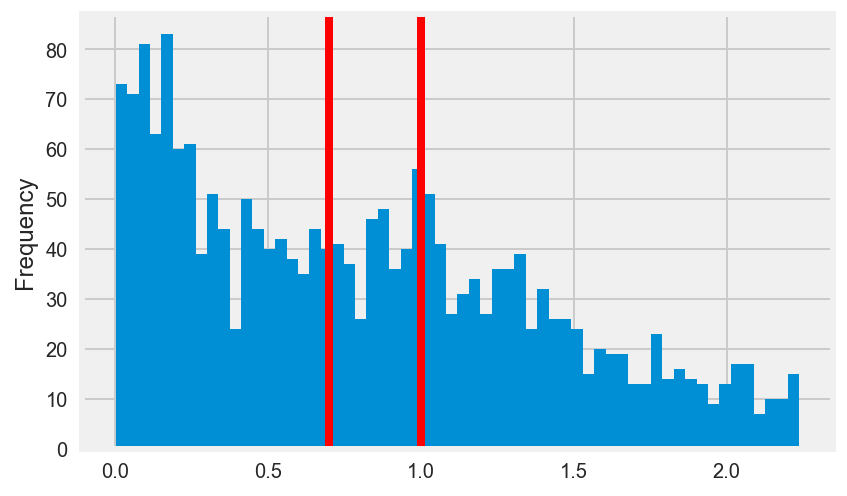

In [13]:
df['e_sq'].plot.hist(bins=60)
plt.axvline(x=0.7,color='red')
plt.axvline(x=1.0,color='red')

In [14]:
df_07_10 = df.query("0.7 < e_sq < 1.0")
print('all objects = {:,}'.format(len(df)))
print('bad objects = {:,}'.format(len(df_07_10)))
print('bad objects percentage = {:.2f}% '.format(len(df_07_10)/len(df)*100) )
df_07_10.head(2).T

all objects = 2,044
bad objects = 330
bad objects percentage = 16.14% 


,19,24
file_number,0.000000,0.00000
id,136.000000,169.00000
base_SdssCentroid_x,1687.716700,1124.50960
base_SdssCentroid_y,163.514200,204.95690
base_SdssCentroid_xSigma,0.111800,0.13540
base_SdssCentroid_ySigma,0.108900,0.09180
ext_shapeHSM_HsmShapeRegauss_e1,0.262400,0.63340
ext_shapeHSM_HsmShapeRegauss_e2,0.947100,-0.68800
base_SdssShape_flux,5491.398300,10528.76050
e_sq,0.965852,0.87454


# Distance of objects in a file from cetroid of that file

In [15]:
!ls

centroids_wcs_psf_f8_lsst.txt        find_centroid.ipynb
centroids_wcs_psf_f8_lsst90.txt      find_centroid_wcs_psf.py
centroids_wcs_psf_f8_lsst_mono.txt   july17_bad_density_of_400files.ipynb
centroids_wcs_psf_f8_lsst_mono90.txt


In [16]:
!head -2 centroids_wcs_psf_f8_lsst.txt

1695 1712
1661 1703


In [17]:
# the first lsst file has centroids = 1695, 1712
x_centroid = 1695
y_centroid = 1712

In [18]:
df.head(1).T

,0
file_number,0.000000
id,30.000000
base_SdssCentroid_x,1877.364300
base_SdssCentroid_y,27.833300
base_SdssCentroid_xSigma,0.330000
base_SdssCentroid_ySigma,0.299100
ext_shapeHSM_HsmShapeRegauss_e1,0.160800
ext_shapeHSM_HsmShapeRegauss_e2,-0.292200
base_SdssShape_flux,3044.910100
e_sq,0.111237


In [19]:
df['radius_sq'] = (df['base_SdssCentroid_x'] - x_centroid)**2 +\
                        (df['base_SdssCentroid_y'] - y_centroid)**2

In [20]:
df.head(2).T

,0,1
file_number,0.000000e+00,0.000000e+00
id,3.000000e+01,4.600000e+01
base_SdssCentroid_x,1.877364e+03,2.075329e+03
base_SdssCentroid_y,2.783330e+01,5.073660e+01
base_SdssCentroid_xSigma,3.300000e-01,1.004000e-01
base_SdssCentroid_ySigma,2.991000e-01,9.650000e-02
ext_shapeHSM_HsmShapeRegauss_e1,1.608000e-01,4.208000e-01
ext_shapeHSM_HsmShapeRegauss_e2,-2.922000e-01,-6.910000e-01
base_SdssShape_flux,3.044910e+03,6.985676e+03
e_sq,1.112375e-01,6.545536e-01


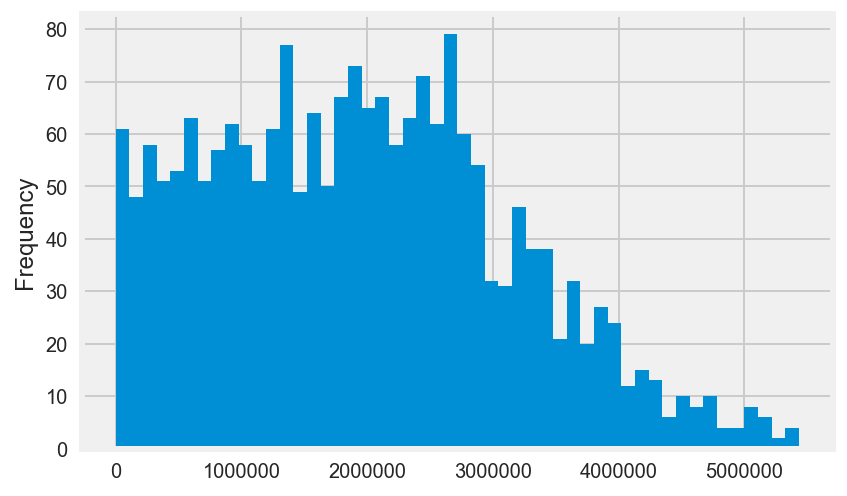

In [21]:
df['radius_sq'].plot.hist(bins=50)

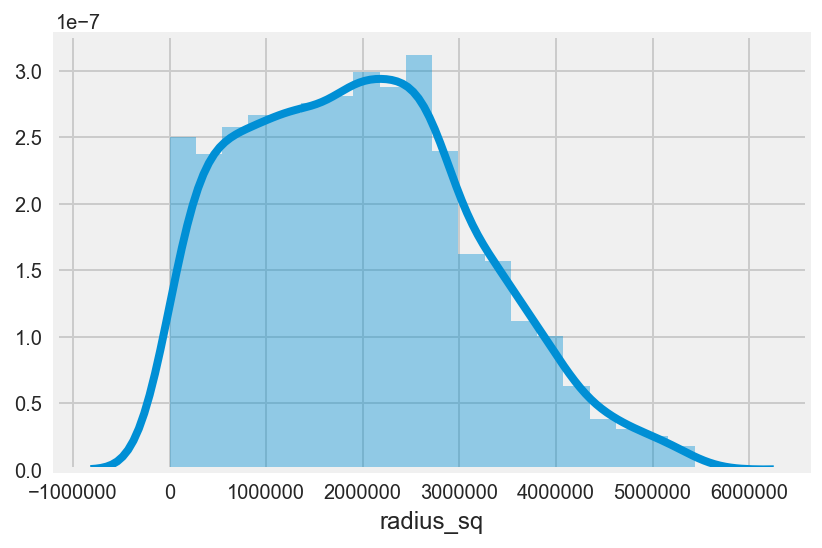

In [22]:
sns.distplot(df['radius_sq'])

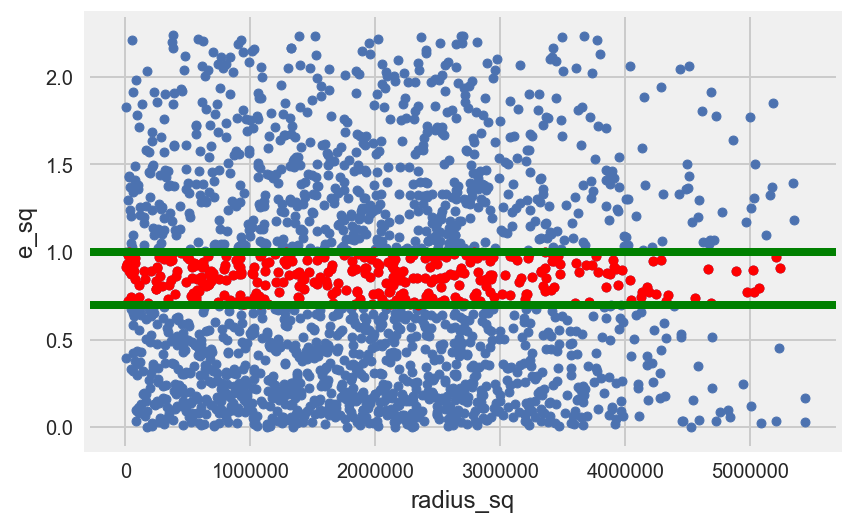

In [23]:
ax=df.plot.scatter(x='radius_sq',y='e_sq')
df.query("0.7 < e_sq < 1").plot.scatter(x='radius_sq',y='e_sq',color='red',ax=ax)
plt.axhline(y=0.7,color='green')
plt.axhline(y=1.0,color='green')

In [24]:
df.query("0.7 < e_sq < 1.0").shape

(330, 11)

In [25]:
len(df.query("0.7 < e_sq < 1.0")) / len(df) * 100

16.14481409001957

# Bad density percentage of 100 lsst files

In [26]:
# infile = '../a08_july5_2019/src_lsst_z1.5_000.txt'

In [27]:
!ls ../a08_july5_2019/*_lsst_[^m9]*.txt | wc -l

     100


In [28]:
!head -2 ../a08_july5_2019/src_lsst_z1.5_000.txt

# file_number           id           base_SdssCentroid_x           base_SdssCentroid_y           base_SdssCentroid_xSigma           base_SdssCentroid_ySigma           ext_shapeHSM_HsmShapeRegauss_e1           ext_shapeHSM_HsmShapeRegauss_e2           base_SdssShape_flux
0.000000000000000000e+00	3.000000000000000000e+01	1.877364299999999957e+03	2.783330000000000126e+01	3.300000000000000155e-01	2.990999999999999770e-01	1.607999999999999985e-01	-2.922000000000000153e-01	3.044910100000000057e+03


In [29]:
lsst_files = !ls ../a08_july5_2019/*_lsst_[^m9]*.txt

In [30]:
lsst_files[0]

'../a08_july5_2019/src_lsst_z1.5_000.txt'

In [31]:
lsst_files[-1]

'../a08_july5_2019/src_lsst_z1.5_099.txt'

In [32]:
bad_percent_lsst = []
col_names = ['file_number', 'id', 'base_SdssCentroid_x', 'base_SdssCentroid_y',
       'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma',
       'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2',
       'base_SdssShape_flux']

In [33]:
df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None,names=col_names)
df['e_sq'] = df['ext_shapeHSM_HsmShapeRegauss_e1']**2 \
        + df['ext_shapeHSM_HsmShapeRegauss_e2']**2

len(df.query("0.7 < e_sq < 1.0")) / len(df) * 100

16.14481409001957

In [34]:
for infile in lsst_files:
    df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None,names=col_names)
    df['e_sq'] = df['ext_shapeHSM_HsmShapeRegauss_e1']**2 \
            + df['ext_shapeHSM_HsmShapeRegauss_e2']**2
    bad_percent = len(df.query("0.7 < e_sq < 1.0")) / len(df) * 100
    bad_percent_lsst.append(bad_percent)

In [36]:
bad_percent_lsst = np.array(bad_percent_lsst).astype(int)
pd.value_counts(bad_percent_lsst)

18    47
17    34
19    12
16     7
dtype: int64

In [37]:
pd.value_counts(bad_percent_lsst).to_frame().reset_index().rename(columns={'index':'bad_percent', 0: 'counts'})

,bad_percent,counts
0,18,47
1,17,34
2,19,12
3,16,7


In [38]:
pd.DataFrame( data = np.array(np.unique(bad_percent_lsst, return_counts=True)).T,
              columns = ['bad_percent','counts'])


,bad_percent,counts
0,16,7
1,17,34
2,18,47
3,19,12


In [ ]:
# all 100 lsst files have bad density 16, 17, 18, or 19
# 47 lsst fitsfiles have 18% percent objects in range 0.7 < e_sq < 1.0